In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

DATA_PATH = os.getenv('TEACHER_DIR', os.getcwd()) + '/JHL_data'

# Autoencoders

The curse of dimensionality makes it increasingly more difficult to work with highly dimensional data such as images. Increasing the data input dimensions results in an explosion for the computational, storage and data requirements. To achieve reliable results, the amount of data needed grows exponentially with the dimensionality.

In the first hands-on we have seen how a simple feed forward neural network learns to classify digits that live in a 784-dimensional space. Is there a way to describe the same digits but by reducing the input information? Could we somehow convert (map) the 784-dimensional space into a lower dimensional one with minimal information loss?

In turns out we can! 

### The Task for the Autoencoder

With a classifier, the goal is to identify datapoints and label them correctly given the training data.
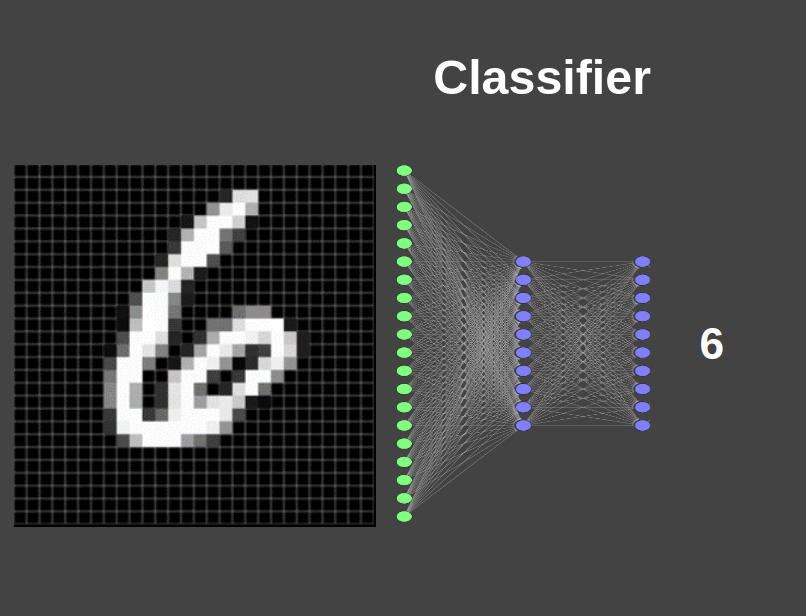

With an autoencoder we want to *reconstruct* the whole image while first encoding the image into a lower dimensional space.

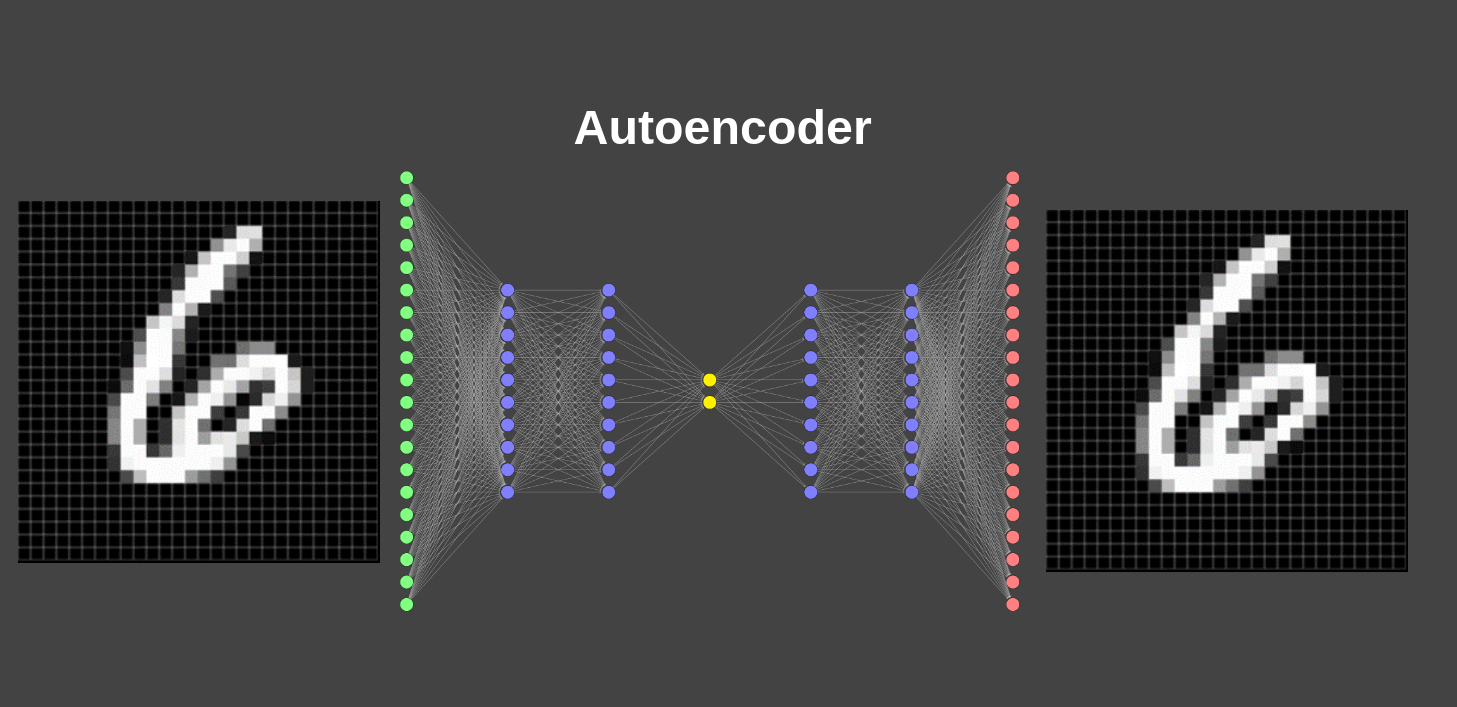

In the case of the autoencoder, there are no labels or explicit targets. We only have the training images which become both our input and output. The target loss function should then only have to compare the input to the output of the neural network. 


## Loading Training Data

We can reuse the MNIST data set loading code:

The MNIST dataset is conveniently bundled within Torch Vision, and we can easily take a look at some of its features.

### Lets take a look at our input data

In [2]:
example_trainset = datasets.MNIST(root=DATA_PATH, train=True, transform=transforms.ToTensor(), download=True)

example_image, example_label = next(iter(example_trainset))

print(f"Input data shape: {example_image.shape}")
example_image = example_image[0] # removing first dimension


Input data shape: torch.Size([1, 28, 28])


### Let's plot the numerical representation of the image so that we can see what the model sees as input!

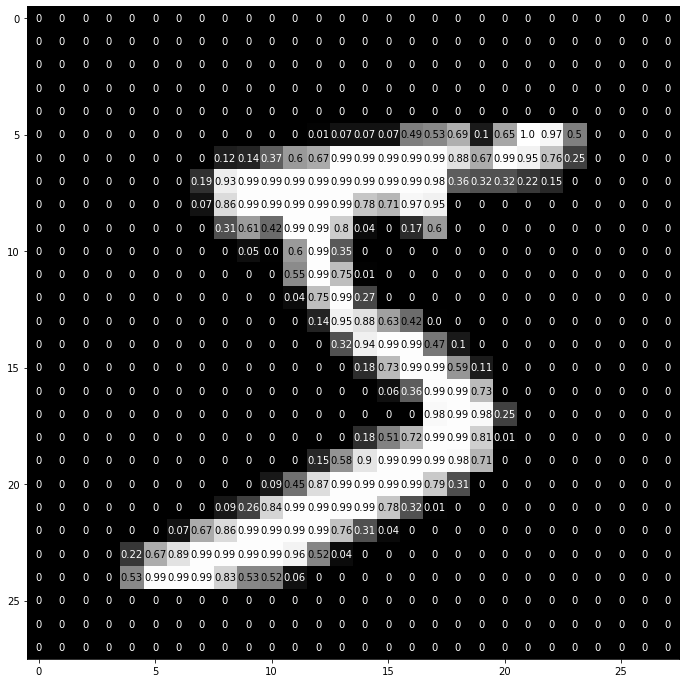

In [3]:
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(example_image, cmap='gray')
width, height = example_image.shape
thresh = example_image.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(example_image[x][y].item(), 2) if example_image[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if example_image[x][y]<thresh else 'black')

# Formatting the input data layer

Remember that instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector.

This will still be the first layer to our autoencoder. The autoencoder will essentially learn to reconstruct a vector.

# Building the model

We saw in the lecture how an Autoencoder has a two-part architecture consisting of an Encoder and a Decoder. The encoder is responsible for compressing the input data to a lower space, while the decoder tries to reconstruct the original image from that lower dimensionality.

As such, we will be using the following architecture:

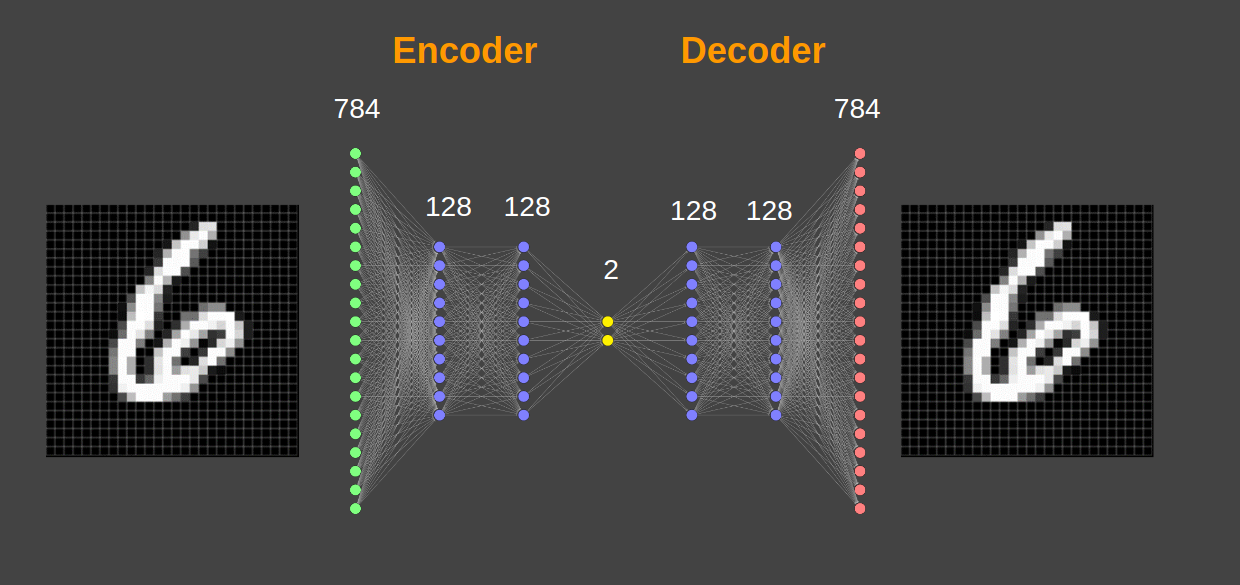



In [4]:
# We can see our autoencoder as consisting of two neural networks
class Encoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        # input -> flatten -> first later -> second layer -> latent vector
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, hidden_dims), nn.ReLU(),
                                     nn.Linear(hidden_dims,hidden_dims), nn.ReLU())
        
        self.latent = nn.Linear(hidden_dims, latent_dims)

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        return x

# the decoder takes a 2-dimensional vector and reconstructs a digit 
class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims):
        super(Decoder, self).__init__()
        # latent vector -> first later -> second layer -> Reconstruction
        self.decoder = nn.Sequential(nn.Linear(latent_dims, hidden_dims), nn.ReLU(),
                                     nn.Linear(hidden_dims,hidden_dims), nn.ReLU())
        
        # The sigmoid here forces the outputs to be between 0 and 1
        self.output = nn.Sequential(nn.Linear(hidden_dims, 784))

    def forward(self, x):
        x = self.decoder(x)
        x = self.output(x)
        # we reshape our output of 784 to 28x28
        x = x.view(-1,1, 28, 28)
        return x

# the AutoEncoder class 'connects' the encoder and decoder together
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super().__init__()  # Python magic which initialises all relevant PyTorch properties
        
        # Here, define your model!
        # We are initializing the encoder and decoder
        
        # hidden_dims=128, latent=2
        self.encoder = Encoder(hidden_dims, latent_dims)
        self.decoder = Decoder(latent_dims, hidden_dims)

                
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### What we want to do to train this model; gradient descent:

Just as the classifier that we trained in the first hands-on; our model is trained using gradient descent. Instead of outputting a probability distribution across ten different digits, we are essentially predicting 784 classes. Each "class" here stands for a pixel value, instead of a class-probability label!

For this purpose we won't be able to use the cross-entropy measure, which is used for categorical outputs (that is, labels). In this task, we want to compare the input with the output. We can simply use the Mean Square error: $\sum (\mathbf{x}-\hat{\mathbf{x}})^2$. Here $\hat{\mathbf{x}}$ is the reconstructed digit and $\mathbf{x}$ is the original digit.

Note how the structure for training this model stays largely the same compared to the first and second hands-on. Remember what we need to train the model:

### What we need to train this model under the hood...
- The calculation and retention of computational graphs when you call model.forward()
- The calculation of gradients when we calculate the loss and call loss.backwards()
- The updating of model parameters when we call optimizer.step()

## The Test loop

The test loop tells us how well we are reconstructing data points that the model has never seen before! We cannot compute an accuracy, so we 
print the MSE on the test data and visualize the reconstructions.


In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    # we don't need the target here!
    for batch_idx, (data, _) in enumerate(train_loader):
        # this is x
        data = data.to(device)
        optimizer.zero_grad()
        
        # this is x hat
        output = model(data)
        # MSE loss
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
           
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # get model output
            output = model(data)
            # calculate loss
            test_loss += F.mse_loss(output, data).item()  # sum up batch loss
                        
    test_loss /= (len(test_loader.dataset)/BATCH_SIZE)
    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
        
    # visualization, we take the first 16 images
    output = torch.cat((data[:9], output[:9].cpu()), dim=0)
    output = make_grid(output, normalize=True, nrow=9).permute(1,2,0).numpy()
    
    return output

### Training hyperparameters and PyTorch boilerplate

In [6]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

CUDA is not available


### Training the model

This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation.
Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size reduces the variance of the update step, which may not always be useful for succesfully training the model due to underfitting. 

Too small of a batch size increases the variance of the update step, which may lead the optimizer to miss the global minimum.

So a good batch size may take some trial and error to find (or hyperparameter optimization...)!

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.971488
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.587478

Test set: Average loss: 0.5775


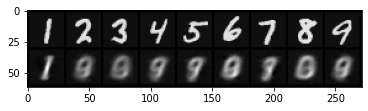

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.570142
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.520618

Test set: Average loss: 0.5330


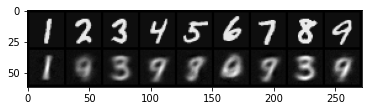

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.537827


KeyboardInterrupt: 

In [9]:
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 1e-4
HIDDEN_DIMS = 128
LATENT_DIMS = 2
LOG_INTERVAL = 600

model = AutoEncoder(HIDDEN_DIMS, LATENT_DIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


transform = transforms.Compose([
    transforms.ToTensor(), # Creates the PyTorch tensors from the PIL images, and normalizes them to the [0, 1] interval 
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the data to 0 mean and 1 standard deviation
])

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.MNIST(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=train
    )
    for train in (True, False)
)

model = model.to(device)

for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
    reconstructions = test(model, device, test_loader)
    
    plt.imshow(reconstructions)
    plt.show()

### (Hopefully) your loss goes down, and your reconstructions make sense!

Tinkering with the hyper parameters will let you converge faster (or slower for that matter). After a few iterations the loss will go down and the reconstructions will start to take shape. With the default configuration, it needs a few tens of epochs to start converging. Can you find a better configuration?



## Generation using an AutoEncoder.

Now that we have an AutoEncoder well trained, is there a way that we can sample from its (two-dimensional) latent space? This neural network should have learnt how the data looks like when encoded to two dimensions. So, in principle we could randomly generate two real numbers and decode them to 'generate' one digit right? Yes and No.

by choosing a point uniformly, by chance, we could find a datapoint that resembles a digit. We never trained the model in a way that guarantees our latent space to be "dense". This means, we will find that our latent space is broken and filled with "gaps" between the datapoints. Furthermore, we are dealing with an easy dataset that is fully representable using a two-dimensional latent space. Not all data can be represented with a low dimensionality and the curse of dimensionality would forbid us to sample something representative in higher dimensions. The space of data in higher dimensions is very sparse. 

### Inspecting the Latent Space

Since our latent space is just two-dimensional, we can plot this and see how the model has learnt the latent space.


In [10]:
def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize = (18,10)) 
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            
            # 1. get output from the model
            # 2. if the output contains more elements than just the latents, discard these
            # 3. convert pytorch tensor to numpy arrays
            z_latent = (
                out[0]
                if isinstance(
                    (out := model.encoder(x.to(device))),
                    tuple
                )
                else out
            ).cpu().numpy()
            
            plt.scatter(z_latent[:, 0], z_latent[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                plt.grid()
                break

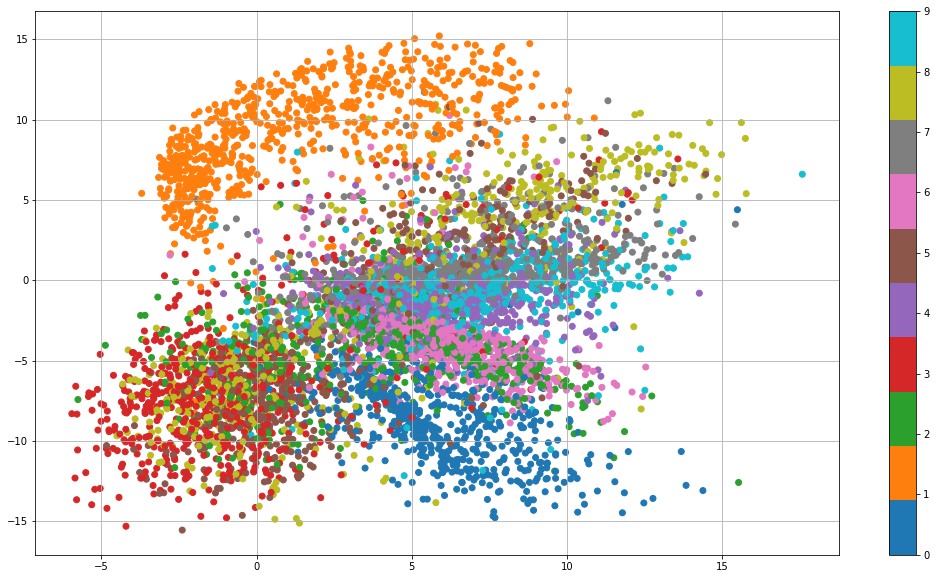

In [11]:
plot_latent(model, test_loader)

## The Learned Latent Space
We can see that there is a lot of overlap between the digit classes. For instance, we can see here the model has difficulty segregating the digit 9 (light blue) from the digit 4 (purple). Ideally, we want these classes to be separated (disentangled) as much as possible from each other.

We can attempt to 'walk' or traverse this learned latent space by uniformly sampling points in sequence:

In [12]:
def plot_reconstructed(model, r0=(0, 20), r1=(-5, 15), n=16):
    model.eval()
    fig = plt.figure(figsize = (12,12)) 
    w = 28
    img = np.zeros((n*w, n*w))
    with torch.no_grad():
        for i, y in enumerate(np.linspace(*r1, n)):
            for j, x in enumerate(np.linspace(*r0, n)):
                latent = torch.Tensor([[x, y]]).to(device)
                x_hat = model.decoder(latent)
                x_hat = x_hat.reshape(28, 28).cpu().numpy()
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
        plt.imshow(img, extent=[*r0, *r1], cmap='magma')



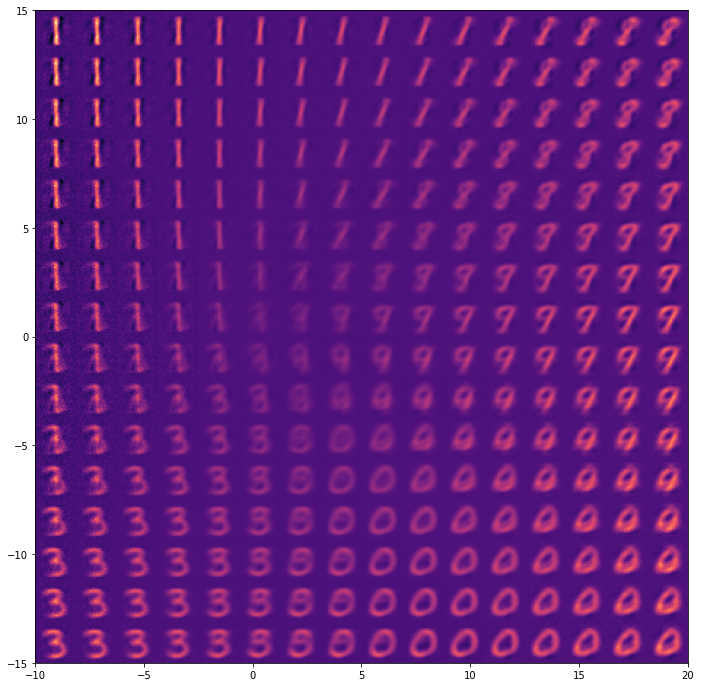

In [13]:
plot_reconstructed(model, r0=(-10, 20), r1=(-15, 15))

Here we see roughly how this traversal takes the shape as the figure above of the learned latent space. Notice how the shapes of the digits between 9, 4 and 0 are incongruous. In the plot we see that there are holes in the latent space. For instance, the model does not "know" what the relationship is between 7 and 1. We need something more powerful to learn the data distribution better and to somehow teach the model to learn a smoother data distribution.

# Variational Auto Encoder

As we saw during the lecture. The (vanilla) VAE looks like a regular regular autoencoder except that we try to learn the data statistics. We do this by parameterizing the Gaussian (Normal) distribution. That is, while an autoencoder learns a deterministic latent, the VAE learns the means and standard deviations of the latent space; a probability distribution. 

The output of the encoder part is replaced by a mean output $\mu(\mathbf{x})$ and a standard deviation output $\sigma(\mathbf{x})$. The decoder takes as input a latent vector sampled from a normal distribution using the learned $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$. In essence, we do not need to change the decoder class that we already have, only the encoder.

<img src="./images/vae.jpg" width="768" height="512" />


In [25]:

# We can largely reuse our previous Encoder, while the decoder remains unchanged.
class VariationalEncoder(nn.Module):    
    def __init__(self, hidden_dims, latent_dims):
        super(VariationalEncoder, self).__init__()
        # input -> flatten -> first later -> second layer -> (means, stds)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, 2*latent_dims)
        )
        

    def forward(self, x):
        mean, logvar = torch.chunk(self.encoder(x), chunks=2, dim=1)
        
        # reparemeterization trick
        z_latent = mean + (0.5 * logvar).exp() * torch.randn_like(mean)
        
        return z_latent, mean, logvar
    
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        self.encoder = VariationalEncoder(hidden_dims, latent_dims)
        self.decoder = Decoder(latent_dims, hidden_dims)

    def forward(self, x):
        z_latent, mu, logvar = self.encoder(x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=-1)
        decoded = self.decoder(z_latent if self.training else mu)
        return decoded, kl_loss
    
    def generate(self, n_digits=16):
        
        sample = torch.distributions.Normal(0, 1).sample((n_digits,self.latent_dims))
        generated = self.decoder(sample)
        return generated        
        

# Training a VAE
Now that we have defined our VAE, we can train this as we saw in the slides. We can reuse the code that above that we used for the autoencoder. However, there are a few changes we have to make such as adding the KL divergence penalty term to force our network to keep close to the standard normal distribution $\mathcal{N}(\mathbf{0}, \mathbf{1})$. 

Remember that this penalty term is needed for encouraging the model to learn a latent space to be more like the standard normal distribution. In this manner we are also disentangling the space more. In our Autoencoder we had the problem that some digit classes overlapped a lot. With a KLD penalty term we are forcing the model to learn the meaningful (separating) properties that constitute the digits. Keep in mind that both the KLD penalty term and the reconstruction loss (MSE) are needed for a smooth representation of the latent space.

In [43]:
def train_vae(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    # we don't need the target here!
    for batch_idx, (data, _) in enumerate(train_loader):
        # this is x
        data = data.to(device)
        optimizer.zero_grad()
        
        output, kl_loss = model(data)

        loss = F.mse_loss(input=output, target=data, reduction='sum') + kl_loss.sum()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))

def test_vae(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for data, _ in test_loader:
            data = data.to(device)
            
            # get model output
            output, _ = model(data)
            
            # calculate loss
            test_loss += F.mse_loss(output, data).item()  # sum up batch loss
                        
    test_loss /= (len(test_loader.dataset)/BATCH_SIZE)
    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
        
    # visualization
    output = torch.cat((data[:9], output[:9].cpu()), dim=0)
    output = make_grid(output, normalize=True, nrow=9).permute(1,2,0).numpy()
    
    return output

In [16]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

CUDA is not available


Train Epoch: 0 [0/60000 (0%)]	Loss: 28677.066406
Train Epoch: 0 [19200/60000 (32%)]	Loss: 12750.060547
Train Epoch: 0 [38400/60000 (64%)]	Loss: 12283.690430
Train Epoch: 0 [57600/60000 (96%)]	Loss: 11315.906250

Test set: Average loss: 0.4668
reconstructions: 


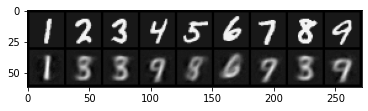

Train Epoch: 1 [0/60000 (0%)]	Loss: 12422.061523
Train Epoch: 1 [19200/60000 (32%)]	Loss: 11233.214844
Train Epoch: 1 [38400/60000 (64%)]	Loss: 12685.732422
Train Epoch: 1 [57600/60000 (96%)]	Loss: 11302.918945

Test set: Average loss: 0.4427
reconstructions: 


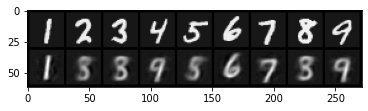

Train Epoch: 2 [0/60000 (0%)]	Loss: 13363.125000


KeyboardInterrupt: 

In [59]:
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
LOG_INTERVAL = 600
HIDDEN_DIMS = 128
LATENT_DIMS = 2

model = VAE(HIDDEN_DIMS, LATENT_DIMS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

transform = transforms.Compose([
    transforms.ToTensor(), # Creates the PyTorch tensors from the PIL images, and normalizes them to the [0, 1] interval 
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the data to 0 mean and 1 standard deviation
])

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.MNIST(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=train
    )
    for train in (True, False)
)

model = model.to(device)

for epoch in range(EPOCHS):
    train_vae(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
    reconstructions = test_vae(model, device, test_loader)
    
    print("reconstructions: ")
    plt.imshow(reconstructions)
    plt.show()

# Generation!

We can now generate from the latent space by sampling from the unit normal distribution $\mathcal{N}(\mathbf{0},\mathbf{1})$. We first sample a two-dimensional latent and then decode it to obtain digits.

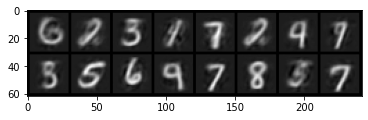

In [55]:
model.eval()
with torch.no_grad():
    generated_digits = model.generate(16)
    # visualization
    generated_digits = generated_digits.cpu()
    generated_digits_grid = make_grid(generated_digits, normalize=True).permute(1,2,0).numpy()
    
    plt.imshow(generated_digits_grid)
    plt.show()

# Let's inspect the VAE latent space

By running the cell below we can peek into the latent space that has been learned by the model. In an instant we see what the addition of the KLD term did to our latent space:

1. The latent space is more disentangled; we can see how (almost) each class has been separated from the rest, and we see this in the generations as well; we can generate better looking data points than we did with the autoencoder.

2. The shape of the latent space seems to be centered and more uniform than the latent space of the autoencoder. This is effectively the purpose of the KLD term; we forced the neural network to approximate the data distribution statistics with a unit gaussian!

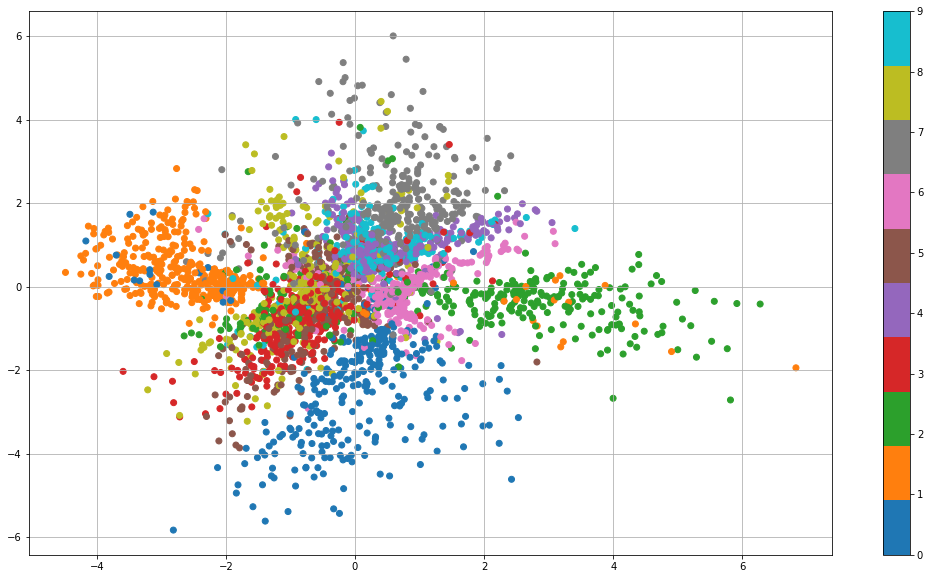

In [60]:
plot_latent(model, test_loader)

# Smooth transitions in our latent space

Let's plot the traversal from one digit to another! We should see no gaps and a smoother transition between the digits!

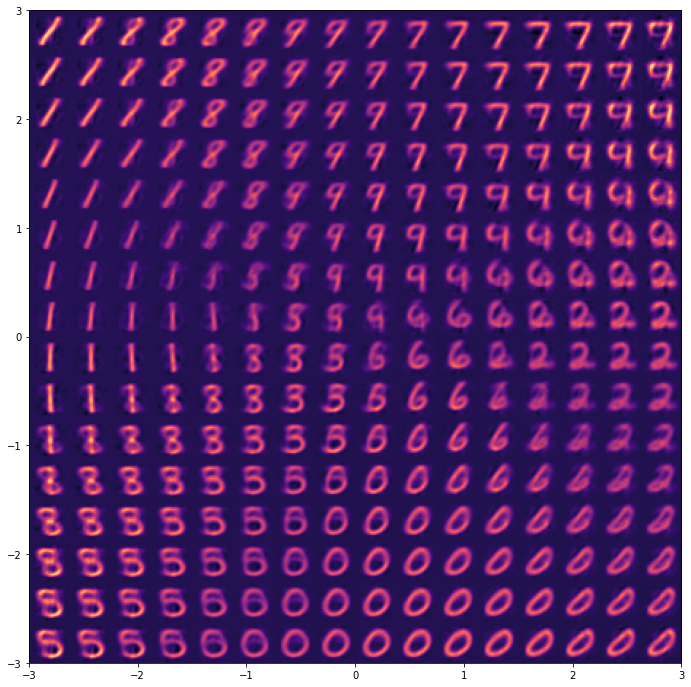

In [61]:
plot_reconstructed(model, r0=(-3, 3), r1=(-3, 3))

# Conclusion

We can reconstruct data using neural networks but the reconstruction does not imply generative capabilities. We have seen how we should engineer an architecture to add generative capabilities by using variational inference. We have seen how a VAE presents us useful properties that help in distinguishing features that identify certain classes without explicitly training on those classes. VAEs simply offer a more disentangled and smooth latent space from which we can generate data points easily.

Now you should try it out! Change whatever parameter, add or remove layers and see what happens. Perhaps try convolutional layers? VAEs are easy to train but you still have to fine tune properly to get some clean results.

# EXTRA: 3D Projection Plotting
We have essentially compressed our data into two dimensions. We lose a lot of information by doing this hard encoding. We can choose to train with bigger latent sizes, but we would lose the ability to plot these and inspect the latent space visually!

If we retrain our model with a latent_dim of 3,visualizing it using a planar plot would mean discarding the information of the third dimension.
However, by adding an axis for the third dimension we can visualize the space nevertheless!

In [57]:
def plot_3d_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize = (18,10))
    ax = fig.add_subplot(projection='3d')
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            # extract the latent
                
            z_latent, _, _ = model.encoder(x.to(device))
                
            # visualize the 3D latent
            z_latent = z_latent.to(device).cpu().numpy()
            ax.scatter(z_latent[:, 0], z_latent[:, 1], z_latent[:,2], c=y, cmap='tab10')
            if i > num_batches:
                plt.grid()
                break
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

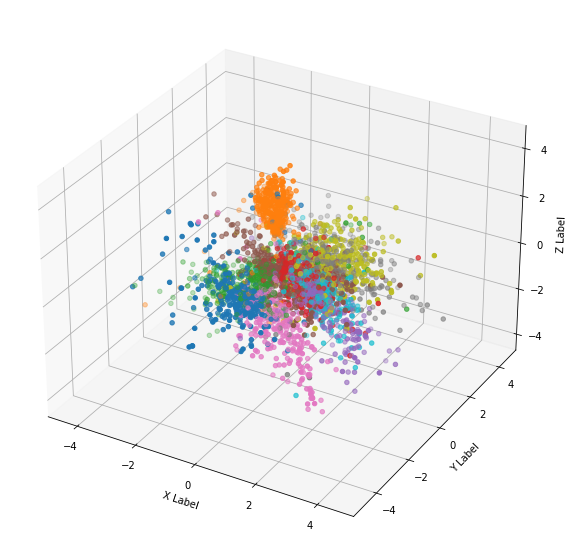

In [58]:
plot_3d_latent(model, test_loader)

# References and more Learning!
1. https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
2. https://avandekleut.github.io/vae/
3. https://hal.archives-ouvertes.fr/hal-02266937/file/LXAI%20at%20ICML%20-%20Oral%20Presentation.pdf
4. https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
5. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
    